# Import Libraries

In [1]:
import os
import pickle
import warnings
import pandas as pd
import numpy as np
import ast
import re
import string
import preprocessor as p
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from gensim.models.fasttext import FastText

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
nltk.download('stopwords')
nltk.download('punkt')
factory = StemmerFactory()
stemmer = factory.create_stemmer()
listStopword =  set(stopwords.words('indonesian'))  

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpawitro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jpawitro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read Data

In [2]:
data = os.path.join("..","data")
model = os.path.join("..","model")

In [3]:
df = pd.read_csv(os.path.join(data,"Dataset_cb.csv"),sep=";", encoding='cp1252',usecols=["Comment","Class"])
df["Class"] = df["Class"].map({1:"Bully",0:"Non-bully"})
df

,Comment,Class
0,"Kaka tidur yaa, udah pagi, gaboleh capek2",Non-bully
1,makan nasi padang aja begini badannya,Non-bully
2,yang aku suka dari dia adalah selalu cukur jem...,Bully
3,Hai kak Isyana aku ngefans banget sama kak Isy...,Non-bully
4,Manusia apa bidadari sih herann deh cantik ter...,Non-bully
...,...,...
645,aku memutuskan untuk menjadi fans isyana. gila...,Non-bully
646,AMZING ISYANAA!! Jujur aku amazed banget denga...,Non-bully
647,paling ngiri liat orang keren maen alat musik ...,Non-bully
648,"Sampe ga bisa berkata2 lagi buat isyana, sanga...",Non-bully


# Exploration

In [4]:
df["Class"].value_counts()

Non-bully    325
Bully        325
Name: Class, dtype: int64

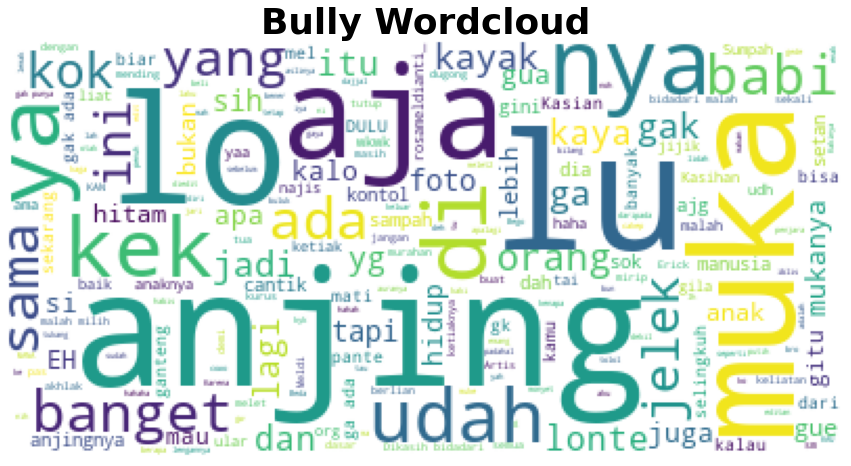

In [5]:
plt.figure(figsize=(15,10))
wordcloud = WordCloud(background_color="white").generate(" ".join(df[df["Class"]=="Bully"]["Comment"].tolist()))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Bully Wordcloud", fontsize=36,fontweight="bold")
plt.show()

# Natural Language Processing

## Cleaning & Case Folding

In [6]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

emoticons = emoticons_happy.union(emoticons_sad)

In [7]:
cleaned = []
for n in df['Comment'].tolist():
    n = p.clean(n)
    n = n.lower()
    n = re.sub(r':', '', n)
    n = re.sub(r'‚Ä¶', '', n)
    n = re.sub(r'[^\x00-\x7F]+',' ', n)
    n = emoji_pattern.sub(r'', n)
    n = re.sub('[^a-zA-Z]', ' ', n)
    n = re.sub("&lt;/?.*?&gt;","&lt;&gt;",n)
    n = re.sub("(\\d|\\W)+"," ",n)
    n = re.sub(r'â', '', n)
    n = re.sub(r'€', '', n)
    n = re.sub(r'¦', '', n)
    cleaned.append(n)

In [8]:
pd.DataFrame(cleaned,columns=["Cleaning"]).head()

,Cleaning
0,kaka tidur yaa udah pagi gaboleh capek
1,makan nasi padang aja begini badannya
2,yang aku suka dari dia adalah selalu cukur jem...
3,hai kak isyana aku ngefans banget sama kak isy...
4,manusia apa bidadari sih herann deh cantik terus


In [9]:
df = df.assign(Cleaning = pd.DataFrame(cleaned,columns=["Cleaning"]))

## Tokenization

In [10]:
file_slang  = open(os.path.join("..","data","cleaning_source","update_combined_slang_words.txt"), "r")
content = file_slang.read()
slang_words = ast.literal_eval(content)

In [11]:
tokenized = []
for n in cleaned:
    n = word_tokenize(n)
    for w in n:
        if w in slang_words.keys():
            n[n.index(w)] = slang_words[w]
    tokenized.append(n)

In [12]:
pd.DataFrame([', '.join(i)for i in tokenized],columns=["Tokenization"]).head()

,Tokenization
0,"kakak, tidur, yaa, sudah, pagi, gaboleh, capek"
1,"makan, nasi, padang, saja, begini, badannya"
2,"yang, aku, suka, dari, dia, adalah, selalu, cu..."
3,"hai, kak, isyana, aku, ngefans, banget, sama, ..."
4,"manusia, apa, bidadari, sih, herann, deh, cant..."


In [13]:
df = df.assign(Tokenization = pd.DataFrame([', '.join(i)for i in tokenized],columns=["Tokenization"]))

## Stopwords, emoticons, punctuation and insignificant words removal

In [14]:
removed = []
listtoberemoved = []
for ts in tokenized:
    n = []
    for t in ts:
        if t not in listtoberemoved and t not in listStopword and t not in emoticons and t not in string.punctuation:
            n.append(t)
    removed.append(n)

In [15]:
pd.DataFrame([', '.join(i)for i in removed],columns=["Stopwords_Removal"]).head()

,Stopwords_Removal
0,"kakak, tidur, yaa, pagi, gaboleh, capek"
1,"makan, nasi, padang, badannya"
2,"suka, cukur, jembut, manggung"
3,"hai, kak, isyana, ngefans, banget, kak, isyana..."
4,"manusia, bidadari, sih, herann, deh, cantik"


In [16]:
df = df.assign(Stopwords_Removal = pd.DataFrame([', '.join(i)for i in removed],columns=["Stopwords_Removal"]))

## Stemming

In [17]:
stemmed = []
for n in removed:
    n = ' '.join(n)
    n = stemmer.stem(n)
    n = n.split(' ')
    stemmed.append(n)

In [18]:
pd.DataFrame([', '.join(i)for i in stemmed],columns=["Stemming"]).head()

,Stemming
0,"kakak, tidur, yaa, pagi, gaboleh, capek"
1,"makan, nasi, padang, badan"
2,"suka, cukur, jembut, manggung"
3,"hai, kak, isyana, ngefans, banget, kak, isyana..."
4,"manusia, bidadari, sih, herann, deh, cantik"


In [19]:
df = df.assign(Stemming = pd.DataFrame([', '.join(i)for i in stemmed],columns=["Stemming"]))

In [20]:
df

,Comment,Class,Cleaning,Tokenization,Stopwords_Removal,Stemming
0,"Kaka tidur yaa, udah pagi, gaboleh capek2",Non-bully,kaka tidur yaa udah pagi gaboleh capek,"kakak, tidur, yaa, sudah, pagi, gaboleh, capek","kakak, tidur, yaa, pagi, gaboleh, capek","kakak, tidur, yaa, pagi, gaboleh, capek"
1,makan nasi padang aja begini badannya,Non-bully,makan nasi padang aja begini badannya,"makan, nasi, padang, saja, begini, badannya","makan, nasi, padang, badannya","makan, nasi, padang, badan"
2,yang aku suka dari dia adalah selalu cukur jem...,Bully,yang aku suka dari dia adalah selalu cukur jem...,"yang, aku, suka, dari, dia, adalah, selalu, cu...","suka, cukur, jembut, manggung","suka, cukur, jembut, manggung"
3,Hai kak Isyana aku ngefans banget sama kak Isy...,Non-bully,hai kak isyana aku ngefans banget sama kak isy...,"hai, kak, isyana, aku, ngefans, banget, sama, ...","hai, kak, isyana, ngefans, banget, kak, isyana...","hai, kak, isyana, ngefans, banget, kak, isyana..."
4,Manusia apa bidadari sih herann deh cantik ter...,Non-bully,manusia apa bidadari sih herann deh cantik terus,"manusia, apa, bidadari, sih, herann, deh, cant...","manusia, bidadari, sih, herann, deh, cantik","manusia, bidadari, sih, herann, deh, cantik"
...,...,...,...,...,...,...
645,aku memutuskan untuk menjadi fans isyana. gila...,Non-bully,aku memutuskan untuk menjadi fans isyana gila ...,"aku, memutuskan, untuk, menjadi, fans, isyana,...","memutuskan, fans, isyana, gila, keren, banget,...","putus, fans, isyana, gila, keren, banget, iya,..."
646,AMZING ISYANAA!! Jujur aku amazed banget denga...,Non-bully,amzing isyanaa jujur aku amazed banget dengan ...,"amzing, isyanaa, jujur, aku, amazed, banget, d...","amzing, isyanaa, jujur, amazed, banget, skill,...","amzing, isyanaa, jujur, amazed, banget, skill,..."
647,paling ngiri liat orang keren maen alat musik ...,Non-bully,paling ngiri liat orang keren maen alat musik ...,"paling, iri, lihat, orang, keren, main, alat, ...","iri, lihat, orang, keren, main, alat, musik, d...","iri, lihat, orang, keren, main, alat, musik, d..."
648,"Sampe ga bisa berkata2 lagi buat isyana, sanga...",Non-bully,sampe ga bisa berkata lagi buat isyana sangat ...,"sampai, ga, bisa, berkata, lagi, buat, isyana,...","ga, isyana, sempurna, orang","ga, isyana, sempurna, orang"


# Fasttext - Text Embedding

In [21]:
ftmod = FastText(stemmed)

In [22]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix

        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}

        for word in temp_vocab:
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()

In [23]:
sequencer = Sequencer(all_words = [token for seq in stemmed for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = ftmod.wv)

In [24]:
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in stemmed])
print(x_vecs.shape)

(650, 1500)


# Label Encoding

In [25]:
le = LabelEncoder()
y = le.fit_transform(df["Class"])
le.classes_

array(['Bully', 'Non-bully'], dtype=object)

# Feature Selecetion

In [26]:
rf = RandomForestClassifier(n_estimators=340)
rf.fit(x_vecs,y)
feat = rf.feature_importances_

In [27]:
dfeat = pd.DataFrame(feat, columns=["feature_importance"])
dfeat = dfeat[dfeat["feature_importance"]>=dfeat.sort_values(by="feature_importance", ascending=True).quantile(0.9).values[0]]
dfeat

,feature_importance
0,0.002084
1,0.003585
2,0.002009
3,0.003217
4,0.002985
...,...
343,0.001970
355,0.002822
407,0.003769
422,0.002325


In [28]:
X = x_vecs[:,dfeat.index]

In [29]:
X = pd.DataFrame(X)

# Split Dataset

In [30]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(520, 150)
(130, 150)
(520,)
(130,)


# Modeling and Parameter Tuning

In [31]:
clf=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [32]:
clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, verbose=2)
    
clf.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.6s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   1.3s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   1.4s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   1.3s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   1.3s
[CV] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500; total time=   1.3

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             verbose=2)

# Results

In [33]:
results = pd.DataFrame(clf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.reset_index(drop=True,inplace=True)
results

In [34]:
clf.best_params_

In [35]:
pred = clf.predict(x_test)
print("================Classification Report================")
print()
print(metrics.classification_report(y_test,pred,target_names=le.classes_))
print()
print()

================Classification Report================

              precision    recall  f1-score   support

       Bully       0.72      0.66      0.69        62
   Non-bully       0.71      0.76      0.74        68

    accuracy                           0.72       130
   macro avg       0.72      0.71      0.71       130
weighted avg       0.72      0.72      0.71       130





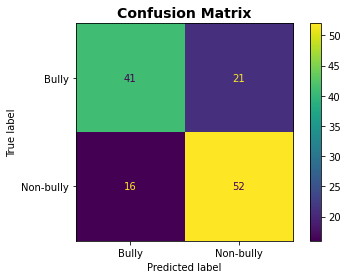

In [36]:
cm = metrics.confusion_matrix(y_test, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.grid(False)
plt.title("Confusion Matrix", fontweight='bold', fontsize=14)
plt.show()

In [37]:
df.iloc[x_test.index,:2].reset_index(drop=True).assign(Pred = pd.DataFrame(le.inverse_transform(pred)))

,Comment,Class,Pred
0,Gua kalai jadi tuhan gaakan gua jadiin dia ini...,Bully,Non-bully
1,Di foto ini ada 2 anjing dan 1 kontol,Bully,Bully
2,hanya bisa melihat hujatan klean kasian si lis...,Non-bully,Non-bully
3,muka kek banci dih najis,Bully,Bully
4,Meldi tambah kurusan sekarang ya??? Cantik wal...,Non-bully,Non-bully
...,...,...,...
125,Dari raut mukanya aja udh terlihat seperti org...,Bully,Bully
126,Apa ganteng nyasih anjing.. Kucel gini jadiin ...,Bully,Bully
127,Ganteng kagak berbakat juga kagak kelebihannya...,Bully,Bully
128,HEH UDH NAPA HATE NYA CAPE GW BACA NYA,Non-bully,Non-bully


# Dump Model

In [38]:
pickle.dump(clf,open(os.path.join(model,"randomforest.sav"),"wb"))
pickle.dump(le,open(os.path.join(model,"le.sav"),"wb"))
dfeat.to_json(os.path.join(model,"feature.json"))
ftmod.save(os.path.join(model,"fasttext.bin"))